# Statcast + FanGraphs 2018 "Breakout" Analysis - xwOBA

In this notebook, I will make an initial attempt at determining which players have a legitimate chance to "breakout" in 2018 based off of their 2017 stats. I'll then apply my methodology to 2015 and 2016 stats to see if "breakout" players did in fact break out or not. I'm using "breakout" in the sense that these players have a higher likelihood to perform above expectation the following season. I realize that is semi vague and I'd like to quantify later on.

Since AB ranges from 75 to 662 in the merged_2017 dataset that I created in a previous notebook, simply looking at BA, H, HR, RBI, etc is not sufficient since those are counting stats. Because of this, I will create more metrics to analyze per AB in an attempt to somewhat normalize players. Once we get down to a final list, I will take out "qualified" players (> 502 ABs for that specific year) as those players are already full timers and my goal is to find more under the radar players.

wOBA - A rate statistic which attempts to credit a hitter for the value of each outcome (single, double, etc) rather than  treating all hits or times on base equally. Batting average and OBP assumes all hits are created equal, slugging weights hits but not accurately and ignores other ways of reaching base. wOBA formulas change year to year because it is based on relative contributions to run scoring and runs scored vary from year to year.

The 2017 formula for wOBA = (0.693×uBB + 0.723×HBP + 0.877×1B + 1.232×2B + 1.552×3B + 1.979×HR) / (AB + BB – IBB + SF + HBP)

xwOBA - A metric that utilizes launch angle and exit velocity to assign a hit value to every batted ball and then translates that into "expected" wOBA. 

In [203]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
%matplotlib inline
pd.set_option("display.max_rows",500)

In [204]:
# read in merged statcast and fangraphs data
merged_2015 = pd.read_csv("C:/Users/avitosky/Documents/Baseball Project/merged_2015.csv", index_col=0)
merged_2016 = pd.read_csv("C:/Users/avitosky/Documents/Baseball Project/merged_2016.csv", index_col=0)
merged_2017 = pd.read_csv("C:/Users/avitosky/Documents/Baseball Project/merged_2017.csv", index_col=0)

In [205]:
# a quick reminder of what our merged data looks like
merged_2017.head()

,Player_Name,PA,AB,Hits,R,HR,RBI,SB,BA,xBA,OBP,BABIP,ISO,SLG,wOBA,xwOBA,BB/PA,K/PA,Launch_Speed,Launch_Angle,Whiffs,Swings,Takes,wRC+,WAR,playerid
0,A.J. Ellis,163,143,30,17,6,14,0,0.210,0.197,0.298,0.222,0.161,0.371,0.294,0.273,0.074,0.178,80.8,16.5,52,270,365,80,0.2,5677
1,A.J. Pollock,466,425,113,73,14,49,20,0.266,0.265,0.330,0.291,0.205,0.471,0.340,0.331,0.075,0.152,82.9,10.7,139,737,995,103,2.1,9256
2,Aaron Altherr,412,372,101,58,19,65,5,0.272,0.244,0.340,0.328,0.245,0.516,0.359,0.330,0.078,0.252,83.3,14.3,212,708,878,120,1.3,11270
3,Aaron Hicks,361,301,80,54,15,52,10,0.266,0.233,0.372,0.290,0.209,0.475,0.363,0.335,0.141,0.186,83.0,16.5,154,579,896,127,3.3,5297
4,Aaron Judge,678,542,154,128,52,114,9,0.284,0.278,0.422,0.357,0.343,0.627,0.430,0.446,0.187,0.307,85.1,17.5,429,1228,1756,173,8.2,15640


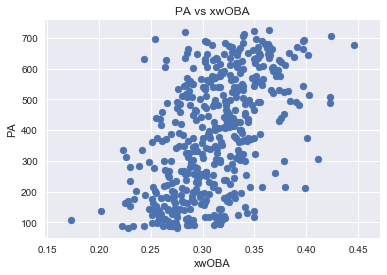

In [206]:
# plot scatter plot of PA vs xwOBA, generally more PA means higher xwOBA (better players play more) but not dramatically
plt.scatter(merged_2017['xwOBA'], merged_2017['PA'])
plt.title('PA vs xwOBA')
plt.xlabel('xwOBA')
plt.ylabel('PA')

plt.show()

First let's start off by creating a simple wOBA - xwOBA column called 'wOBA_diff' and see who our initial underperformers and 
overperformers were for 2017 based on wOBA and xwOBA.

In [257]:
# top 15 underperformers - Cabrera, Moreland stick out here
merged_2017 ['wOBA_diff'] = merged_2017['wOBA'] -  merged_2017['xwOBA']
merged_2017.sort_values(by='wOBA_diff').head(15)

,Player_Name,PA,AB,Hits,R,HR,RBI,SB,BA,xBA,OBP,BABIP,ISO,SLG,wOBA,xwOBA,BB/PA,K/PA,Launch_Speed,Launch_Angle,Whiffs,Swings,Takes,wRC+,WAR,playerid,wOBA_diff,HR/PA,R/PA,RBI/PA,SB/PA,Whiffs/PA,Swings/PA,Takes/PA
292,Luis Torrens,139,123,20,7,0,7,0,0.163,0.217,0.243,0.215,0.041,0.203,0.197,0.267,0.086,0.216,79.5,9.5,68,261,271,18,-0.8,15905,-0.070,0.000000,0.050360,0.050360,0.000000,0.489209,1.877698,1.949640
327,Miguel Cabrera,529,469,117,50,16,60,0,0.249,0.290,0.329,0.292,0.149,0.399,0.313,0.382,0.102,0.208,84.5,17.5,237,1028,1014,91,-0.2,1744,-0.069,0.030246,0.094518,0.113422,0.000000,0.448015,1.943289,1.916824
248,Jose Lobaton,158,141,24,11,4,11,0,0.170,0.225,0.248,0.194,0.106,0.277,0.232,0.301,0.089,0.222,79.8,13.3,76,303,322,36,-0.6,4243,-0.069,0.025316,0.069620,0.069620,0.000000,0.481013,1.917722,2.037975
372,Rob Refsnyder,98,88,15,8,0,0,4,0.170,0.221,0.247,0.211,0.045,0.216,0.209,0.274,0.082,0.173,82.3,9.4,33,148,205,22,-0.7,13770,-0.065,0.000000,0.081633,0.000000,0.040816,0.336735,1.510204,2.091837
361,Paulo Orlando,90,86,17,9,2,6,1,0.198,0.255,0.225,0.234,0.105,0.302,0.228,0.292,0.011,0.222,82.8,15.7,52,173,119,34,-0.4,8628,-0.064,0.022222,0.100000,0.066667,0.011111,0.577778,1.922222,1.322222
344,Nick Franklin,119,106,19,9,2,12,2,0.179,0.248,0.269,0.207,0.104,0.283,0.250,0.312,0.084,0.185,79.1,11.7,46,197,273,48,-0.2,10166,-0.062,0.016807,0.075630,0.100840,0.016807,0.386555,1.655462,2.294118
188,Hyun Soo Kim,239,212,49,20,1,14,0,0.231,0.262,0.307,0.287,0.061,0.292,0.268,0.321,0.092,0.192,82.0,14.4,77,414,567,61,-1.1,18718,-0.053,0.004184,0.083682,0.058577,0.000000,0.322176,1.732218,2.372385
379,Ruben Tejada,124,113,26,17,0,5,0,0.230,0.266,0.293,0.265,0.053,0.283,0.259,0.311,0.065,0.121,81.8,16.3,33,220,226,56,-0.2,5519,-0.052,0.000000,0.137097,0.040323,0.000000,0.266129,1.774194,1.822581
44,Austin Romine,252,229,50,19,2,21,0,0.218,0.254,0.272,0.277,0.074,0.293,0.250,0.297,0.063,0.226,79.8,14.6,123,467,481,49,-0.6,5491,-0.047,0.007937,0.075397,0.083333,0.000000,0.488095,1.853175,1.908730
261,Juan Graterol,87,84,17,5,0,10,0,0.202,0.246,0.207,0.233,0.048,0.250,0.196,0.243,0.011,0.149,78.4,7.9,37,162,115,16,-0.4,5398,-0.047,0.000000,0.057471,0.114943,0.000000,0.425287,1.862069,1.321839


In [258]:
# top 15 overperformers - Marwin, Cozart and again xwOBA doesn't adjust for speed as shown below
merged_2017.sort_values(by='wOBA_diff', ascending=False).head(15)

,Player_Name,PA,AB,Hits,R,HR,RBI,SB,BA,xBA,OBP,BABIP,ISO,SLG,wOBA,xwOBA,BB/PA,K/PA,Launch_Speed,Launch_Angle,Whiffs,Swings,Takes,wRC+,WAR,playerid,wOBA_diff,HR/PA,R/PA,RBI/PA,SB/PA,Whiffs/PA,Swings/PA,Takes/PA
357,Pat Valaika,195,182,47,28,13,40,0,0.258,0.211,0.284,0.291,0.275,0.533,0.338,0.255,0.036,0.272,79.1,18.7,123,382,303,92,0.6,14885,0.083,0.066667,0.143590,0.205128,0.000000,0.630769,1.958974,1.553846
157,Eric Young Jr.,125,110,29,24,4,16,12,0.264,0.198,0.336,0.333,0.155,0.418,0.329,0.251,0.040,0.248,78.4,7.2,66,220,204,108,0.8,7158,0.078,0.032000,0.192000,0.128000,0.096000,0.528000,1.760000,1.632000
147,Eduardo Nunez,491,467,146,60,12,58,24,0.313,0.246,0.341,0.333,0.148,0.460,0.342,0.275,0.037,0.110,80.5,13.8,150,911,802,112,2.2,6848,0.067,0.024440,0.122200,0.118126,0.048880,0.305499,1.855397,1.633401
297,Mallex Smith,282,256,69,33,2,12,16,0.270,0.199,0.329,0.347,0.086,0.355,0.301,0.239,0.082,0.220,74.0,9.3,152,501,543,88,0.8,13608,0.062,0.007092,0.117021,0.042553,0.056738,0.539007,1.776596,1.925532
308,Marwin Gonzalez,515,455,138,67,23,90,8,0.303,0.244,0.377,0.343,0.226,0.530,0.382,0.320,0.095,0.192,82.6,13.2,182,891,1211,144,4.1,5497,0.062,0.044660,0.130097,0.174757,0.015534,0.353398,1.730097,2.351456
454,Zack Cozart,507,438,130,80,24,63,3,0.297,0.255,0.385,0.312,0.251,0.548,0.392,0.332,0.122,0.154,81.7,16.3,139,868,1249,141,5.0,2616,0.060,0.047337,0.157791,0.124260,0.005917,0.274162,1.712032,2.463511
128,Delino DeShields,440,376,101,75,6,22,29,0.269,0.191,0.347,0.358,0.098,0.367,0.315,0.255,0.100,0.248,76.7,12.5,165,707,1082,90,2.3,11379,0.060,0.013636,0.170455,0.050000,0.065909,0.375000,1.606818,2.459091
274,Kevin Kiermaier,421,380,105,56,15,39,16,0.276,0.215,0.338,0.337,0.174,0.450,0.337,0.279,0.074,0.235,79.8,14.5,212,792,853,112,3.0,11038,0.058,0.035629,0.133017,0.092637,0.038005,0.503563,1.881235,2.026128
127,Dee Gordon,695,653,201,114,2,33,60,0.308,0.237,0.341,0.354,0.067,0.375,0.312,0.254,0.036,0.134,75.7,6.9,186,1256,1087,92,3.3,8203,0.058,0.002878,0.164029,0.047482,0.086331,0.267626,1.807194,1.564029
245,Jose Altuve,662,590,204,112,24,81,32,0.346,0.274,0.410,0.370,0.202,0.547,0.405,0.349,0.088,0.127,81.0,13.4,185,1099,1195,160,7.5,5417,0.056,0.036254,0.169184,0.122356,0.048338,0.279456,1.660121,1.805136


In [209]:
# creating new per PA percentage metrics
merged_2015 ['HR/PA'] = merged_2015['HR'] /  merged_2015['PA']
merged_2016 ['HR/PA'] = merged_2016['HR'] /  merged_2016['PA']
merged_2017 ['HR/PA'] = merged_2017['HR'] /  merged_2017['PA']
merged_2015 ['R/PA'] = merged_2015['R'] /  merged_2015['PA']
merged_2016 ['R/PA'] = merged_2016['R'] /  merged_2016['PA']
merged_2017 ['R/PA'] = merged_2017['R'] /  merged_2017['PA']
merged_2015 ['RBI/PA'] = merged_2015['RBI'] /  merged_2015['PA']
merged_2016 ['RBI/PA'] = merged_2016['RBI'] /  merged_2016['PA']
merged_2017 ['RBI/PA'] = merged_2017['RBI'] /  merged_2017['PA']
merged_2015 ['SB/PA'] = merged_2015['SB'] /  merged_2015['PA']
merged_2016 ['SB/PA'] = merged_2016['SB'] /  merged_2016['PA']
merged_2017 ['SB/PA'] = merged_2017['SB'] /  merged_2017['PA']
merged_2015 ['Whiffs/PA'] = merged_2015['Whiffs'] /  merged_2015['PA']
merged_2016 ['Whiffs/PA'] = merged_2016['Whiffs'] /  merged_2016['PA']
merged_2017 ['Whiffs/PA'] = merged_2017['Whiffs'] /  merged_2017['PA']
merged_2015 ['Swings/PA'] = merged_2015['Swings'] /  merged_2015['PA']
merged_2016 ['Swings/PA'] = merged_2016['Swings'] /  merged_2016['PA']
merged_2017 ['Swings/PA'] = merged_2017['Swings'] /  merged_2017['PA']
merged_2015 ['Takes/PA'] = merged_2015['Takes'] /  merged_2015['PA']
merged_2016 ['Takes/PA'] = merged_2016['Takes'] /  merged_2016['PA']
merged_2017 ['Takes/PA'] = merged_2017['Takes'] /  merged_2017['PA']

In [210]:
# taking out counting stats and creating datasets with just rate stats for deeper analysis, keep PA as a reference point
# most interested in how xwOBA and wOBA correlate so putting them towards the front

rate_stats_2015 = merged_2015.filter(['Player_Name', 'PA', 'xwOBA', 'wOBA', 'BA', 'xBA', 'OBP', 'BB/PA', 'K/PA', 'Launch_Speed', 
                                      'Launch_Angle', 'BABIP', 'ISO', 'SLG',  'HR/PA', 'R/PA', 'RBI/PA', 'SB/PA', 
                                      'Whiffs/PA', 'Swings/PA', 'Takes/PA'], axis=1)
rate_stats_2016 = merged_2016.filter(['Player_Name', 'PA', 'xwOBA', 'wOBA', 'BA', 'xBA', 'OBP', 'BB/PA', 'K/PA', 'Launch_Speed', 
                                      'Launch_Angle', 'BABIP', 'ISO', 'SLG',  'HR/PA', 'R/PA', 'RBI/PA', 'SB/PA', 
                                      'Whiffs/PA', 'Swings/PA', 'Takes/PA'], axis=1)
rate_stats_2017 = merged_2017.filter(['Player_Name', 'PA', 'xwOBA', 'wOBA', 'BA', 'xBA', 'OBP', 'BB/PA', 'K/PA', 'Launch_Speed', 
                                      'Launch_Angle', 'BABIP', 'ISO', 'SLG',  'HR/PA', 'R/PA', 'RBI/PA', 'SB/PA', 
                                      'Whiffs/PA', 'Swings/PA', 'Takes/PA'], axis=1)

In [211]:
# let's look at our new dataset for 2017
rate_stats_2017.head()

,Player_Name,PA,xwOBA,wOBA,BA,xBA,OBP,BB/PA,K/PA,Launch_Speed,Launch_Angle,BABIP,ISO,SLG,HR/PA,R/PA,RBI/PA,SB/PA,Whiffs/PA,Swings/PA,Takes/PA
0,A.J. Ellis,163,0.273,0.294,0.210,0.197,0.298,0.074,0.178,80.8,16.5,0.222,0.161,0.371,0.036810,0.104294,0.085890,0.000000,0.319018,1.656442,2.239264
1,A.J. Pollock,466,0.331,0.340,0.266,0.265,0.330,0.075,0.152,82.9,10.7,0.291,0.205,0.471,0.030043,0.156652,0.105150,0.042918,0.298283,1.581545,2.135193
2,Aaron Altherr,412,0.330,0.359,0.272,0.244,0.340,0.078,0.252,83.3,14.3,0.328,0.245,0.516,0.046117,0.140777,0.157767,0.012136,0.514563,1.718447,2.131068
3,Aaron Hicks,361,0.335,0.363,0.266,0.233,0.372,0.141,0.186,83.0,16.5,0.290,0.209,0.475,0.041551,0.149584,0.144044,0.027701,0.426593,1.603878,2.481994
4,Aaron Judge,678,0.446,0.430,0.284,0.278,0.422,0.187,0.307,85.1,17.5,0.357,0.343,0.627,0.076696,0.188791,0.168142,0.013274,0.632743,1.811209,2.589971


In [212]:
# a look at correlation between all rate stats, sorted by xwOBA
rate_stats_2017.corr().sort_values(by='xwOBA', ascending=False)

,PA,xwOBA,wOBA,BA,xBA,OBP,BB/PA,K/PA,Launch_Speed,Launch_Angle,BABIP,ISO,SLG,HR/PA,R/PA,RBI/PA,SB/PA,Whiffs/PA,Swings/PA,Takes/PA
xwOBA,0.518200,1.000000,0.823467,0.533680,0.766802,0.751825,0.554829,-0.195193,0.645139,0.224597,0.236109,0.677389,0.758200,0.607224,0.467414,0.591037,-0.187462,-0.096309,-0.098816,0.256429
wOBA,0.537792,0.823467,1.000000,0.789975,0.630058,0.894772,0.445814,-0.147622,0.460735,0.185048,0.547763,0.748893,0.927742,0.645413,0.678424,0.634759,0.009776,-0.044350,-0.039190,0.182542
xBA,0.503943,0.766802,0.630058,0.745330,1.000000,0.620190,0.089368,-0.599747,0.432762,-0.091323,0.354041,0.297335,0.562181,0.210450,0.315083,0.396814,-0.084176,-0.417623,-0.116456,-0.078738
SLG,0.522764,0.758200,0.927742,0.685917,0.562181,0.669816,0.231445,-0.040718,0.506109,0.295744,0.410699,0.904453,1.000000,0.819635,0.629829,0.772791,-0.045754,0.118790,0.144225,0.014837
OBP,0.468414,0.751825,0.894772,0.787141,0.620190,1.000000,0.609870,-0.283864,0.317580,0.000944,0.612258,0.413369,0.669816,0.301659,0.596937,0.355923,0.074175,-0.256150,-0.258285,0.324185
ISO,0.399265,0.677389,0.748893,0.310031,0.297335,0.413369,0.288615,0.206795,0.530718,0.471265,0.088253,1.000000,0.904453,0.952514,0.518901,0.779297,-0.143605,0.317958,0.213543,0.091102
Launch_Speed,0.358465,0.645139,0.460735,0.221798,0.432762,0.317580,0.276684,-0.008786,1.000000,0.239353,0.034540,0.530718,0.506109,0.497111,0.222907,0.502370,-0.315203,0.047826,-0.104862,0.204214
HR/PA,0.345566,0.607224,0.645413,0.202257,0.210450,0.301659,0.238867,0.276418,0.497111,0.480974,-0.012610,0.952514,0.819635,1.000000,0.416015,0.771772,-0.187473,0.388562,0.269415,0.052674
RBI/PA,0.328848,0.591037,0.634759,0.393410,0.396814,0.355923,0.116789,0.041924,0.502370,0.338213,0.133475,0.779297,0.772791,0.771772,0.341698,1.000000,-0.244776,0.199138,0.204345,-0.033105
BB/PA,0.171868,0.554829,0.445814,0.022529,0.089368,0.609870,1.000000,0.085075,0.276684,0.182623,0.020766,0.288615,0.231445,0.238867,0.309690,0.116789,-0.084228,-0.084457,-0.377850,0.722242


In [213]:
# 2016 xWOBA correlations
rate_stats_2016.corr().sort_values('xwOBA', ascending=False)

,PA,xwOBA,wOBA,BA,xBA,OBP,BB/PA,K/PA,Launch_Speed,Launch_Angle,BABIP,ISO,SLG,HR/PA,R/PA,RBI/PA,SB/PA,Whiffs/PA,Swings/PA,Takes/PA
xwOBA,0.522343,1.000000,0.799264,0.519971,0.770199,0.725085,0.493599,-0.156240,0.698957,0.177131,0.264013,0.641972,0.734246,0.598881,0.408658,0.596144,-0.186578,-0.052088,-0.111752,0.289609
wOBA,0.565675,0.799264,1.000000,0.788777,0.626954,0.889832,0.394794,-0.120760,0.498414,0.163817,0.613564,0.728449,0.926953,0.597112,0.666003,0.621101,0.042403,-0.009047,-0.032023,0.211742
xBA,0.510603,0.770199,0.626954,0.753677,1.000000,0.618923,0.020446,-0.591028,0.490512,-0.089401,0.382849,0.262848,0.555758,0.186670,0.311453,0.381355,-0.060254,-0.421649,-0.143506,-0.064830
SLG,0.548810,0.734246,0.926953,0.680817,0.555758,0.659979,0.183282,-0.005492,0.561737,0.298468,0.473555,0.891218,1.000000,0.773106,0.631388,0.753830,-0.034514,0.153099,0.154774,0.041700
OBP,0.488093,0.725085,0.889832,0.791485,0.618923,1.000000,0.556912,-0.276325,0.325465,-0.039480,0.670902,0.376217,0.659979,0.245456,0.572589,0.350051,0.128962,-0.230657,-0.248829,0.339116
Launch_Speed,0.387655,0.698957,0.498414,0.251817,0.490512,0.325465,0.233332,0.054296,1.000000,0.171958,0.076478,0.581611,0.561737,0.601924,0.183760,0.538245,-0.295310,0.147421,-0.029886,0.169715
ISO,0.402498,0.641972,0.728449,0.274586,0.262848,0.376217,0.263933,0.281886,0.581611,0.459128,0.128541,1.000000,0.891218,0.939497,0.494311,0.769579,-0.165784,0.387563,0.221815,0.133329
HR/PA,0.356836,0.598881,0.597112,0.121866,0.186670,0.245456,0.254784,0.345182,0.601924,0.466338,-0.033030,0.939497,0.773106,1.000000,0.381373,0.747733,-0.221501,0.439815,0.236106,0.146599
RBI/PA,0.405472,0.596144,0.621101,0.354885,0.381355,0.350051,0.124183,0.065959,0.538245,0.351010,0.129866,0.769579,0.753830,0.747733,0.327705,1.000000,-0.226616,0.233628,0.218242,-0.017145
PA,1.000000,0.522343,0.565675,0.513671,0.510603,0.488093,0.122484,-0.276738,0.387655,0.081651,0.251597,0.402498,0.548810,0.356836,0.450066,0.405472,0.106208,-0.155702,-0.040901,0.008948


In [214]:
# and finally 2015 xWOBA correlations
rate_stats_2015.corr().sort_values('xwOBA', ascending=False)

,PA,xwOBA,wOBA,BA,xBA,OBP,BB/PA,K/PA,Launch_Speed,Launch_Angle,BABIP,ISO,SLG,HR/PA,R/PA,RBI/PA,SB/PA,Whiffs/PA,Swings/PA,Takes/PA
xwOBA,0.457350,1.000000,0.839536,0.572040,0.808166,0.781818,0.576344,-0.163452,0.733438,0.273972,0.363072,0.679738,0.778572,0.630086,0.448491,0.649832,-0.162701,-0.009867,-0.043205,0.287290
wOBA,0.470927,0.839536,1.000000,0.801373,0.698272,0.902726,0.445687,-0.182994,0.604984,0.165851,0.621261,0.756187,0.944439,0.640588,0.632337,0.667723,0.019146,-0.032415,-0.001100,0.223007
xBA,0.520299,0.808166,0.698272,0.783199,1.000000,0.703219,0.152586,-0.544486,0.473702,-0.013551,0.476799,0.339876,0.624943,0.274050,0.340622,0.467240,-0.041180,-0.344109,-0.069487,-0.013969
OBP,0.476116,0.781818,0.902726,0.820990,0.703219,1.000000,0.578034,-0.339381,0.440806,0.027487,0.676057,0.440285,0.717720,0.319806,0.533422,0.419519,0.105577,-0.230209,-0.186453,0.307700
SLG,0.426829,0.778572,0.944439,0.703570,0.624943,0.717720,0.276394,-0.063935,0.649262,0.245328,0.511379,0.892547,1.000000,0.790894,0.622678,0.775551,-0.046247,0.104638,0.137374,0.103359
Launch_Speed,0.287837,0.733438,0.604984,0.296095,0.473702,0.440806,0.392284,0.179781,1.000000,0.328752,0.224378,0.681310,0.649262,0.681807,0.267789,0.653080,-0.319412,0.291767,0.130291,0.227040
ISO,0.250868,0.679738,0.756187,0.307559,0.339876,0.440285,0.348893,0.223047,0.681310,0.417095,0.167016,1.000000,0.892547,0.940113,0.538592,0.788925,-0.167161,0.333227,0.186744,0.186918
RBI/PA,0.334756,0.649832,0.667723,0.393378,0.467240,0.419519,0.207794,0.011145,0.653080,0.286905,0.172980,0.788925,0.775551,0.783028,0.379766,1.000000,-0.245832,0.185497,0.183407,0.050427
HR/PA,0.220870,0.630086,0.640588,0.187311,0.274050,0.319806,0.307524,0.286526,0.681807,0.440168,0.037083,0.940113,0.790894,1.000000,0.432308,0.783028,-0.255771,0.396043,0.217788,0.166091
BB/PA,0.133585,0.576344,0.445687,0.034015,0.152586,0.578034,1.000000,0.093212,0.392284,0.240440,0.034552,0.348893,0.276394,0.307524,0.256915,0.207794,-0.068895,0.023369,-0.347475,0.686347


It's important to step back here and digest these correlations. Obviously wOBA is highly correlated with xwOBA because xwOBA is derived from wOBA so we will not use wOBA in our analysis. SLG and ISO both take an old school approach at accounting for power meaning that their weights don't fluctuate with the season and for that reason I'm not going to use them either. That leaves us with the next three highest correlated variables being 'xBA', 'OBP', and 'Launch_Speed', which I'll use going forward.

In [215]:
# creating datasets with the variables we care about (for now at least) to analyze
rate_stats_2015 = merged_2015.filter(['Player_Name', 'PA', 'xwOBA', 'wOBA', 'xBA', 'OBP', 'Launch_Speed'], axis=1)
rate_stats_2016 = merged_2016.filter(['Player_Name', 'PA', 'xwOBA', 'wOBA', 'xBA', 'OBP', 'Launch_Speed'], axis=1)
rate_stats_2017 = merged_2017.filter(['Player_Name', 'PA', 'xwOBA', 'wOBA', 'xBA', 'OBP', 'Launch_Speed'], axis=1)

In [216]:
# let's start with Launch_Speed - Correa, Abreu, Stanton, are familiar whereas Diaz Avila, Olson are not, let's keep digging
rate_stats_2017.sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
443,Yandy Diaz,179,0.331,0.306,0.266,0.352,87.1
23,Alex Avila,376,0.401,0.362,0.272,0.387,86.4
386,Ryan Zimmerman,576,0.375,0.387,0.286,0.358,85.8
80,Carlos Correa,481,0.393,0.394,0.302,0.391,85.8
244,Jose Abreu,675,0.364,0.377,0.287,0.354,85.8
173,Giancarlo Stanton,692,0.398,0.410,0.266,0.376,85.6
316,Matt Olson,216,0.380,0.411,0.251,0.352,85.4
269,Kendrys Morales,608,0.358,0.320,0.275,0.308,85.4
330,Miguel Sano,483,0.348,0.361,0.235,0.352,85.4
11,Adam Lind,301,0.379,0.363,0.291,0.362,85.4


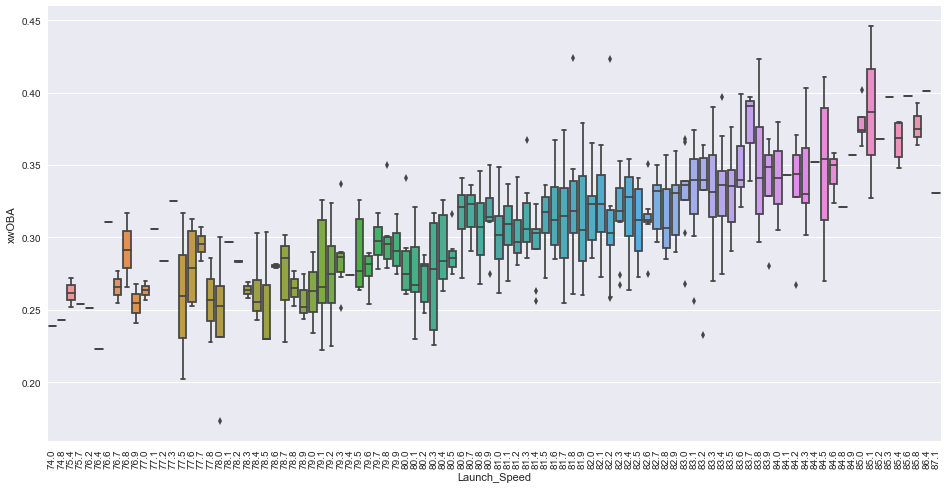

In [217]:
# obviously hitting the ball harder gives a greater chance for success but here it is visually
plt.figure(figsize = (16,8))
sns.boxplot(x='Launch_Speed', y = 'xwOBA', data = rate_stats_2017)
xt = plt.xticks(rotation=90)

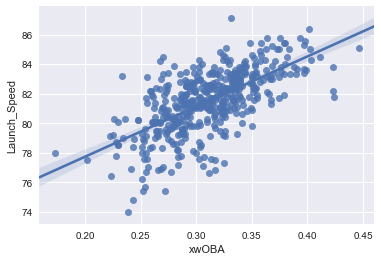

In [218]:
# here's a scatter plot with a regression line. I peeked in the data and that outlier on the  far right is none other than
# Aaron Judge with an almost 0.450 xwOBA and 85 Launch_Speed, wow! Could we have predicted that based on 2016 data? Maybe...
sns.regplot(x="xwOBA", y="Launch_Speed", data=rate_stats_2017)

At this point, I'm going to start segmenting the data to narrow down to find breakout candidates. I will start by looking at the top 25% of players in 'Launch_Speed' from 2017 data and go from there. 

In [219]:
# breaking down 'Launch_Speed' for 2017
rate_stats_2017['Launch_Speed'].describe()

count    456.000000
mean      81.481140
std        2.117513
min       74.000000
25%       80.100000
50%       81.700000
75%       83.000000
max       87.100000
Name: Launch_Speed, dtype: float64

In [220]:
# let's look at all players with Launch_Speed > 83.0, pretty good starting point with this group
# Yandy Diaz, who the heck? I googled him and wow this guy is JACKED, take a look at the link yourself below
# https://cdn-mf0.heartyhosting.com/sites/mensfitness.com/files/yandy-diaz-indians-jacked-1280.jpg
rate_stats_2017[rate_stats_2017.Launch_Speed > 83.0].sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
443,Yandy Diaz,179,0.331,0.306,0.266,0.352,87.1
23,Alex Avila,376,0.401,0.362,0.272,0.387,86.4
386,Ryan Zimmerman,576,0.375,0.387,0.286,0.358,85.8
244,Jose Abreu,675,0.364,0.377,0.287,0.354,85.8
80,Carlos Correa,481,0.393,0.394,0.302,0.391,85.8
173,Giancarlo Stanton,692,0.398,0.410,0.266,0.376,85.6
316,Matt Olson,216,0.380,0.411,0.251,0.352,85.4
330,Miguel Sano,483,0.348,0.361,0.235,0.352,85.4
269,Kendrys Morales,608,0.358,0.320,0.275,0.308,85.4
11,Adam Lind,301,0.379,0.363,0.291,0.362,85.4


In [221]:
# our initial list starts off at 109, let's work on narrowing it down some
print(len(rate_stats_2017[rate_stats_2017.Launch_Speed > 83]))

109


In [222]:
# looking at 2017 'BA' breakdown
rate_stats_2017['xBA'].describe()

count    456.000000
mean       0.239596
std        0.028484
min        0.156000
25%        0.220000
50%        0.242000
75%        0.259250
max        0.322000
Name: xBA, dtype: float64

In [223]:
# and 2017 'OBP'
rate_stats_2017['OBP'].describe()

count    456.000000
mean       0.321586
std        0.041196
min        0.176000
25%        0.294000
50%        0.323000
75%        0.350000
max        0.454000
Name: OBP, dtype: float64

In [224]:
# 0.200 'BA' and 0.300 'OBP' are usually major cutoffs for playing time in MLB let's stay consistent with our 25% cutoff
rate_stats_2017_v2 = rate_stats_2017[(rate_stats_2017.Launch_Speed > 83.0) & 
                                     (rate_stats_2017.xBA > 0.25925) & (rate_stats_2017.OBP > 0.350)]

In [225]:
# sorting by'PA', Lind is a part time player, but Winker, Diaz, Barnes, Martinez are all very interesting...
# the rest were full time starters in 2017 and in pretty good company to be honest
rate_stats_2017_v2.sort_values(by='PA')

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
220,Jesse Winker,137,0.350,0.384,0.278,0.375,83.1
443,Yandy Diaz,179,0.331,0.306,0.266,0.352,87.1
41,Austin Barnes,262,0.370,0.386,0.278,0.408,83.4
11,Adam Lind,301,0.379,0.363,0.291,0.362,85.4
249,Jose Martinez,307,0.411,0.379,0.322,0.379,84.5
323,Michael Brantley,375,0.344,0.342,0.288,0.357,83.8
23,Alex Avila,376,0.401,0.362,0.272,0.387,86.4
263,Justin Bour,429,0.374,0.374,0.277,0.366,83.1
80,Carlos Correa,481,0.393,0.394,0.302,0.391,85.8
193,J.D. Martinez,489,0.423,0.430,0.288,0.376,83.8


In [226]:
# from 109 down to 33, nice
print(len(rate_stats_2017_v2))

39


In [227]:
# Launch_Speed was also highest correlated with xWOBA in 2016 so let's see how it is broken down
rate_stats_2016['Launch_Speed'].describe()

count    459.000000
mean      83.332462
std        2.248195
min       76.400000
25%       81.800000
50%       83.600000
75%       84.900000
max       88.600000
Name: Launch_Speed, dtype: float64

In [228]:
# in 2016, the top 25% cutoff is 84.9 so we'll look at everything above that
rate_stats_2016[rate_stats_2016.Launch_Speed > 84.9].sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
108,Christian Yelich,659,0.381,0.367,0.294,0.376,88.6
311,Matt Holliday,426,0.354,0.335,0.268,0.322,88.3
271,Kendrys Morales,618,0.399,0.339,0.300,0.327,88.0
148,Domingo Santana,281,0.355,0.343,0.264,0.345,87.9
124,Daniel Murphy,582,0.403,0.408,0.320,0.390,87.7
340,Nelson Cruz,667,0.398,0.383,0.280,0.360,87.7
326,Miguel Cabrera,679,0.459,0.399,0.340,0.393,87.7
86,Carlos Santana,688,0.387,0.370,0.276,0.366,87.6
134,David Ortiz,626,0.438,0.419,0.316,0.401,87.6
294,Mac Williamson,127,0.322,0.317,0.223,0.315,87.6


In [229]:
# starting at 108 in 2016 after 109 in 2017 so similar numbers which is good
print(len(rate_stats_2016[rate_stats_2016.Launch_Speed > 84.9]))

108


In [230]:
# cut down to 108, similar numbers to 2017, now let's sort by 'PA' and see who 'should' have broken out in 2017
# The man, the myth, the legend Aaron Judge, there he is. Should we just stop now?!?
# Judge, Moustakas, Pham, Sanchez, Santana fit initial criteria and had great seasons, albeit others that didn't pan out
rate_stats_2016[rate_stats_2016.Launch_Speed > 84.9].sort_values(by='PA')

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
175,Geovany Soto,86,0.352,0.345,0.290,0.321,85.1
130,Darin Ruf,89,0.309,0.245,0.247,0.236,86.8
6,Aaron Judge,95,0.284,0.267,0.184,0.263,85.5
233,Joey Wendle,104,0.297,0.265,0.267,0.298,86.9
411,Teoscar Hernandez,112,0.274,0.308,0.200,0.304,85.2
40,Anthony Recker,112,0.417,0.361,0.299,0.394,85.9
331,Mike Moustakas,113,0.375,0.339,0.294,0.301,87.0
248,Jose Lobaton,114,0.351,0.301,0.271,0.319,85.4
336,Mitch Haniger,123,0.320,0.303,0.229,0.309,86.4
294,Mac Williamson,127,0.322,0.317,0.223,0.315,87.6


In [231]:
# now let's look at 2016 BA and OBP just like we did for 2017
rate_stats_2016['xBA'].describe()

count    459.000000
mean       0.243619
std        0.029207
min        0.156000
25%        0.224000
50%        0.245000
75%        0.264000
max        0.340000
Name: xBA, dtype: float64

In [232]:
# and 2016 OBP
rate_stats_2016['OBP'].describe()

count    459.000000
mean       0.317536
std        0.040320
min        0.105000
25%        0.295000
50%        0.318000
75%        0.346000
max        0.441000
Name: OBP, dtype: float64

In [233]:
# cutoffs for our exercise for 2016 are 84.9 for 'Launch_Speed', 0.264 for 'xBA', and 0.346 for 'OBP'
rate_stats_2016_v2 = rate_stats_2016[(rate_stats_2016.Launch_Speed > 84.9) & (rate_stats_2016.xBA > 0.264) 
                                     & (rate_stats_2016.OBP > 0.346) & (rate_stats_2016.PA < 502)]

In [234]:
# goodbye to Mr. Judge and a much smaller group here but Bour, Sanchez, Turner all hit very well in 2017
rate_stats_2016_v2.sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
263,Justin Bour,321,0.382,0.343,0.284,0.349,87.2
399,Shin-Soo Choo,210,0.385,0.334,0.276,0.357,86.4
173,Gary Sanchez,229,0.395,0.425,0.274,0.376,86.3
189,Hyun Soo Kim,346,0.349,0.352,0.275,0.382,86.2
40,Anthony Recker,112,0.417,0.361,0.299,0.394,85.9
406,Steve Pearce,302,0.365,0.371,0.268,0.374,85.8
424,Trea Turner,324,0.340,0.395,0.286,0.370,85.2


In [235]:
# since our list is loaded with superstars, why don't we try dropping down from top 25% to top 50% threshold and try again
rate_stats_2016_v3 = rate_stats_2016[(rate_stats_2016.Launch_Speed > 83.6) & (rate_stats_2016.xBA > 0.245) & 
                                     (rate_stats_2016.OBP > 0.318) & (rate_stats_2016.PA < 502)]
rate_stats_2016_v3.sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
311,Matt Holliday,426,0.354,0.335,0.268,0.322,88.3
148,Domingo Santana,281,0.355,0.343,0.264,0.345,87.9
358,Pedro Alvarez,376,0.359,0.349,0.263,0.322,87.3
263,Justin Bour,321,0.382,0.343,0.284,0.349,87.2
170,Franklin Gutierrez,283,0.368,0.336,0.259,0.329,87.1
399,Shin-Soo Choo,210,0.385,0.334,0.276,0.357,86.4
173,Gary Sanchez,229,0.395,0.425,0.274,0.376,86.3
189,Hyun Soo Kim,346,0.349,0.352,0.275,0.382,86.2
188,Hunter Pence,442,0.334,0.349,0.254,0.357,86.2
433,Tyler Flowers,325,0.347,0.338,0.248,0.357,86.0


There are several players in this list who ended up breaking out like Bour, Santana, Sanchez, Bell, Contreras, to name a few. It's important to note that not every player from the list broke out in 2017 so I will take my "breakout" list with a grain of salt once it is finalized.

In [236]:
# what if we expand 2017 to the top 50% instead of the top 25%?
rate_stats_2017_v3 = rate_stats_2017[(rate_stats_2017.Launch_Speed > 81.7) & (rate_stats_2017.xBA > 0.242) & 
                                     (rate_stats_2017.OBP > 0.323) & (rate_stats_2017.PA < 502)]

In [237]:
# this is quite the list if I must say so myself, not all of these players have a shot at being a full timer but a majority do
rate_stats_2017_v3.sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
443,Yandy Diaz,179,0.331,0.306,0.266,0.352,87.1
23,Alex Avila,376,0.401,0.362,0.272,0.387,86.4
80,Carlos Correa,481,0.393,0.394,0.302,0.391,85.8
11,Adam Lind,301,0.379,0.363,0.291,0.362,85.4
316,Matt Olson,216,0.380,0.411,0.251,0.352,85.4
395,Seth Smith,373,0.350,0.332,0.264,0.340,84.6
249,Jose Martinez,307,0.411,0.379,0.322,0.379,84.5
453,Yunel Escobar,381,0.330,0.318,0.272,0.333,84.3
431,Victor Martinez,435,0.344,0.303,0.271,0.324,84.2
420,Trea Turner,447,0.305,0.338,0.245,0.338,84.0


In [238]:
# when dropping down to 50% levels, our list expands to 104 but also includes a lot of already full time players
print(len(rate_stats_2017_v3))

41


In [239]:
# let's take that list one step further and only include players with < 502 PA, pretty good looking list to me
# one issue I do see is that it includes full time players who were hurt in 2017, will adjust for that later
rate_stats_2017_v3 = rate_stats_2017[(rate_stats_2017.Launch_Speed > 81.7) & (rate_stats_2017.xBA > 0.242) 
                                     & (rate_stats_2017.OBP > 0.323) & (rate_stats_2017.PA < 502)]
rate_stats_2017_v3.sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
443,Yandy Diaz,179,0.331,0.306,0.266,0.352,87.1
23,Alex Avila,376,0.401,0.362,0.272,0.387,86.4
80,Carlos Correa,481,0.393,0.394,0.302,0.391,85.8
11,Adam Lind,301,0.379,0.363,0.291,0.362,85.4
316,Matt Olson,216,0.380,0.411,0.251,0.352,85.4
395,Seth Smith,373,0.350,0.332,0.264,0.340,84.6
249,Jose Martinez,307,0.411,0.379,0.322,0.379,84.5
453,Yunel Escobar,381,0.330,0.318,0.272,0.333,84.3
431,Victor Martinez,435,0.344,0.303,0.271,0.324,84.2
420,Trea Turner,447,0.305,0.338,0.245,0.338,84.0


In [240]:
# now let's take a look at 2015 stats and see how they stack up
rate_stats_2015['Launch_Speed'].describe()

count    467.000000
mean      86.553747
std        2.722148
min       78.000000
25%       84.800000
50%       86.900000
75%       88.500000
max       95.400000
Name: Launch_Speed, dtype: float64

In [241]:
# BA for 2015
rate_stats_2015['xBA'].describe()

count    467.000000
mean       0.241713
std        0.031366
min        0.139000
25%        0.222000
50%        0.244000
75%        0.261000
max        0.333000
Name: xBA, dtype: float64

In [242]:
# OBP for 2015
rate_stats_2015['OBP'].describe()

count    467.000000
mean       0.312143
std        0.042466
min        0.163000
25%        0.289500
50%        0.314000
75%        0.339000
max        0.460000
Name: OBP, dtype: float64

In [243]:
# and inputting 50% threshold for 2015
rate_stats_2015_v3 = rate_stats_2015[(rate_stats_2015.Launch_Speed > 86.9) & (rate_stats_2015.xBA > 0.244) & 
                                     (rate_stats_2015.OBP > 0.314)& (rate_stats_2015.PA < 502)]

In [244]:
# on this list, there are definitely some breakouts and some duds but the top of the list is pretty dang good
# I am scratching my head on how the 50% Launch_Speed went from 86.9 in 2015 down to 81.7 in 2016?!? 
rate_stats_2015_v3.sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
192,Giancarlo Stanton,318,0.413,0.394,0.276,0.346,95.4
345,Michael Conforto,194,0.370,0.359,0.277,0.335,92.1
196,Greg Bird,178,0.379,0.372,0.259,0.343,91.2
379,Pedro Alvarez,491,0.347,0.333,0.257,0.318,90.8
431,Tommy Pham,173,0.352,0.352,0.270,0.347,90.8
283,Justin Bour,446,0.328,0.343,0.249,0.321,90.6
286,Justin Ruggiano,141,0.367,0.349,0.248,0.333,90.5
171,Enrique Hernandez,218,0.316,0.359,0.264,0.346,90.3
131,Danny Valencia,378,0.348,0.367,0.271,0.345,90.0
207,Hunter Pence,223,0.335,0.347,0.254,0.327,89.5


Before finalizing our 2018 "breakout" list, let's do a quick check and see how many of the players on our breakout list have exceeded the 502 PA threshold in 2015 or 2016. My reasoning for this is that there are some stars on the breakout list who were hurt in 2017, hence why they didn't make the cut of 502 PA. Because of this I'm going to remove those who have had > 502 PA in a previous dataset.

In [245]:
# create 2016 PA check dataset
PA_check_2016 = rate_stats_2016[(rate_stats_2016.PA >= 502)]

In [246]:
# 2018 "breakout" players who had >= 502 PA in 2016, we will exclude them in our final dataset
common_2016 = rate_stats_2017_v3.merge(PA_check_2016,on=['Player_Name','Player_Name'])
rate_stats_2017_v3[(rate_stats_2017_v3.Player_Name.isin(common_2016.Player_Name))]

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
54,Brandon Belt,451,0.379,0.352,0.260,0.355,81.9
70,Bryce Harper,492,0.390,0.416,0.283,0.413,83.3
80,Carlos Correa,481,0.393,0.394,0.302,0.391,85.8
136,Dexter Fowler,491,0.355,0.358,0.266,0.363,81.9
185,Howie Kendrick,334,0.334,0.361,0.270,0.368,82.7
193,J.D. Martinez,489,0.423,0.430,0.288,0.376,83.8
256,Josh Donaldson,496,0.384,0.396,0.254,0.385,83.3
381,Ryan Braun,425,0.344,0.347,0.263,0.336,83.5
431,Victor Martinez,435,0.344,0.303,0.271,0.324,84.2
449,Yoenis Cespedes,321,0.351,0.369,0.262,0.352,82.1


In [247]:
# create 2015 PA check dataset
PA_check_2015 = rate_stats_2015[(rate_stats_2015.PA >= 502)]

In [248]:
# 2018 "breakout" players who had >= 502 PA in 2015, we will exclude them in our final dataset
common_2015 = rate_stats_2017_v3.merge(PA_check_2015,on=['Player_Name','Player_Name'])
rate_stats_2017_v3[(rate_stats_2017_v3.Player_Name.isin(common_2015.Player_Name))]

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
1,A.J. Pollock,466,0.331,0.340,0.265,0.330,82.9
11,Adam Lind,301,0.379,0.363,0.291,0.362,85.4
43,Austin Jackson,318,0.335,0.371,0.271,0.387,82.1
54,Brandon Belt,451,0.379,0.352,0.260,0.355,81.9
70,Bryce Harper,492,0.390,0.416,0.283,0.413,83.3
136,Dexter Fowler,491,0.355,0.358,0.266,0.363,81.9
193,J.D. Martinez,489,0.423,0.430,0.288,0.376,83.8
256,Josh Donaldson,496,0.384,0.396,0.254,0.385,83.3
323,Michael Brantley,375,0.344,0.342,0.288,0.357,83.8
381,Ryan Braun,425,0.344,0.347,0.263,0.336,83.5


In [249]:
# and finally our potential breakout list sorted by Launch_Speed, subject to expected playing time and draft/auction values!
potential_hitting_breakouts_2018 = rate_stats_2017_v3[(~rate_stats_2017_v3.Player_Name.isin(common_2016.Player_Name)) & 
                   (~rate_stats_2017_v3.Player_Name.isin(common_2015.Player_Name)) ]
potential_hitting_breakouts_2018.sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
443,Yandy Diaz,179,0.331,0.306,0.266,0.352,87.1
23,Alex Avila,376,0.401,0.362,0.272,0.387,86.4
316,Matt Olson,216,0.380,0.411,0.251,0.352,85.4
395,Seth Smith,373,0.350,0.332,0.264,0.340,84.6
249,Jose Martinez,307,0.411,0.379,0.322,0.379,84.5
420,Trea Turner,447,0.305,0.338,0.245,0.338,84.0
219,Jeimer Candelario,142,0.316,0.342,0.243,0.359,83.8
324,Michael Conforto,440,0.376,0.392,0.254,0.384,83.8
369,Rhys Hoskins,212,0.399,0.417,0.255,0.396,83.6
41,Austin Barnes,262,0.370,0.386,0.278,0.408,83.4


In [250]:
# final list count
print(len(potential_hitting_breakouts_2018))

26


In [251]:
# and to be consistent if we want to narrow our list to top 25% "breakouts", a more concise and confident list if you will
potential_hitting_breakouts_2018[(potential_hitting_breakouts_2018.Launch_Speed > 83.0) & 
                        (potential_hitting_breakouts_2018.xBA > 0.25925) & 
                        (potential_hitting_breakouts_2018.OBP > 0.350)].sort_values(by='Launch_Speed', ascending=False)

,Player_Name,PA,xwOBA,wOBA,xBA,OBP,Launch_Speed
443,Yandy Diaz,179,0.331,0.306,0.266,0.352,87.1
23,Alex Avila,376,0.401,0.362,0.272,0.387,86.4
249,Jose Martinez,307,0.411,0.379,0.322,0.379,84.5
41,Austin Barnes,262,0.370,0.386,0.278,0.408,83.4
220,Jesse Winker,137,0.350,0.384,0.278,0.375,83.1
263,Justin Bour,429,0.374,0.374,0.277,0.366,83.1


In my opinion, both of these lists have a lot of potential just depends how much research you'd like to do on each player. There are players on the 50% list who will likely not see full playing time in 2018 like La Stella, Nava, Smith, Aoki but there is a good reason why these select players fit our "breakout" criteria so I suppose anything can happen!